**A percepção dos usuários de redes sociais sobre a tecnologia de NFT e suas aplicações analisadas sob a ótica da análise de sentimentos com processamento de linguagem natural**

PARTE 3: Aplicação do dicionário léxico VADER (Valence Aware Dictionary for Sentiment Reasoning) em um modelo de análise de sentimentos/emoções para a avaliação de tweets

No campo de estudo da Análise de Conteúdo em textos, a análise de sentimentos representa um método para a realização de uma Analise Relacional de conteúdo, em que o foco da pesquisa é extrair sentido não somente da presença dos conceitos, mas também da relação entre esses conceitos no texto, e pode ser definida como “Um método que busca compreender a emoção dos conceitos presentes no texto, geralmente através de análises temáticas e de elementos relacionados a essas emoções” (SILVA, 2018,p.15) 

## Importações e referências

https://towardsdatascience.com/sentimental-analysis-using-vader-a3415fef7664#:~:text=VADER%20(%20Valence%20Aware%20Dictionary%20for,directly%20to%20unlabeled%20text%20data.



https://dgarcia-eu.github.io/SocialDataScience/3_Affect/032_UnsupervisedSentimentAnalysis/UnsupervisedSentimentAnalysis.html



https://towardsdatascience.com/unsupervised-sentiment-analysis-a38bf1906483


In [ ]:
# Analise de dados
import pandas as pd
import numpy as np

# bibliotecas para manipulação de texto
import re, string

# VADER
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Exportação em Excel
!pip install xlsxwriter

# Explorações gráficas
import matplotlib.pyplot as plt
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# Para a contagem da Frequência de palavras
from nltk import FreqDist

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [ ]:
df = pd.read_excel('/content/opiniao_modelo.xlsx', index_col=0)
df_avaliacao = pd.read_excel('/content/avaliacao_modelo.xlsx')

In [ ]:
# Visualizando o dataset de avaliação do modelo
df_avaliacao.head(3)

,indice,texto_original,texto_limpo,compound,avaliacao
0,58734,"point one, correct\npoint two, incorrect\n#nft...","point one, correct\npoint two, incorrect\n",0.0000,0
1,58735,nft degenerate who hacked hovercar blocked me ...,nft degenerate who hacked hovercar blocked me,-0.5859,-1
2,58738,@d_r_houston i love the motion in this!! beaut...,i love the motion in this!! beautiful!,0.8934,1


In [ ]:
# Visualizando o dataset principal com os dados rotulados
df.head(3)

,data,texto_original,texto,token,modelo
0,2022-02-09 23:59:59,@kezynfts @sadboyz_nft what an interesting pro...,what an interesting project,"['interesting', 'project']",opinion
1,2022-02-09 23:59:59,look how cute this nft is 😍 check em out https...,look how cute this nft is 😍 check em out,"['look', 'cute', '😍', 'check', 'em']",opinion
2,2022-02-09 23:59:58,@ai_mai_nft done,done,['do'],spam


In [ ]:
df_avaliacao.texto_limpo[1]

'nft degenerate who hacked hovercar blocked me '

In [ ]:
df_avaliacao.texto_original[1]

'nft degenerate who hacked hovercar blocked me https://t.co/zjvrwrayuk'

In [ ]:
# Tamanho do dataset completo 
len(df)

60000

In [ ]:
# Tamanho do dataset de avaliacao
len(df_avaliacao)

500

In [ ]:
'''
texto_unido = []
for c in df_avaliacao.texto:
  texto_unido.append("".join(s for s in c).replace("'","").replace("[","").replace(",","").replace("]","").replace("discord",""))
df_avaliacao['texto'] = texto_unido
df_avaliacao.head()
'''

'\ntexto_unido = []\nfor c in df_avaliacao.texto:\n  texto_unido.append("".join(s for s in c).replace("\'","").replace("[","").replace(",","").replace("]","").replace("discord",""))\ndf_avaliacao[\'texto\'] = texto_unido\ndf_avaliacao.head()\n'

In [ ]:
# Removendo os números para melhorar o processamento do VADER
texto_unido = []
for c in df.texto:
  a = re.sub(r'[0-9]+', '', str(c)).replace('"',"").replace(".","")
  texto_unido.append(a)
df['texto'] = texto_unido
df.head()

,data,texto_original,texto,token,modelo
0,2022-02-09 23:59:59,@kezynfts @sadboyz_nft what an interesting pro...,what an interesting project,"['interesting', 'project']",opinion
1,2022-02-09 23:59:59,look how cute this nft is 😍 check em out https...,look how cute this nft is 😍 check em out,"['look', 'cute', '😍', 'check', 'em']",opinion
2,2022-02-09 23:59:58,@ai_mai_nft done,done,['do'],spam
3,2022-02-09 23:59:58,#nft this is the new collection of the washi a...,this is the new collection of the washi artist...,"['new', 'collection', 'washi', 'artist', 'limit']",spam
4,2022-02-09 23:59:58,"@legaleagle @bmc_nft offers massive utility, s...","offers massive utility, super community, aaa+ ...","['offer', 'massive', 'utility', 'super', 'comm...",opinion


## VADER

O VADER (Valence Aware Dictionary for Sentiment Reasoning) é um dicionário léxico criado com uma combinação de métodos quantitativos e qualitativos desenvolvido e testado em diferentes contextos, mas com desempenho especialmente melhor em textos no formato de micro-blog, tal como postagens de redes sociais como o Twiter (Hutto & Gilbert, 2014). 

### Criando e testando o modelo

In [ ]:
sid = SentimentIntensityAnalyzer()
df_vader_av = df_avaliacao.copy()

In [ ]:
# Aplicando sobre o texto original:
df_vader_av['scores'] = df_vader_av['texto_limpo'].apply( lambda texto: sid.polarity_scores(texto)) 
df_vader_av.head()

,indice,texto_original,texto_limpo,compound,avaliacao,scores
0,58734,"point one, correct\npoint two, incorrect\n#nft...","point one, correct\npoint two, incorrect\n",0.0000,0,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
1,58735,nft degenerate who hacked hovercar blocked me ...,nft degenerate who hacked hovercar blocked me,-0.5859,-1,"{'neg': 0.49, 'neu': 0.51, 'pos': 0.0, 'compou..."
2,58738,@d_r_houston i love the motion in this!! beaut...,i love the motion in this!! beautiful!,0.8934,1,"{'neg': 0.0, 'neu': 0.292, 'pos': 0.708, 'comp..."
3,58739,@harvmcmblocks @whiskers_nft @ricosfilm looks ...,looks so dope. wanna get my hands on these,0.0000,1,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
4,58740,@harvmcmblocks @whiskers_nft @ricosfilm so coo...,so cool!!,0.4900,1,"{'neg': 0.0, 'neu': 0.239, 'pos': 0.761, 'comp..."


In [ ]:
df_vader_av['compound'] = df_vader_av['scores'].apply( lambda score_dict: score_dict['compound']) 
df_vader_av.head(3)

,indice,texto_original,texto_limpo,compound,avaliacao,scores
0,58734,"point one, correct\npoint two, incorrect\n#nft...","point one, correct\npoint two, incorrect\n",0.0000,0,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
1,58735,nft degenerate who hacked hovercar blocked me ...,nft degenerate who hacked hovercar blocked me,-0.5859,-1,"{'neg': 0.49, 'neu': 0.51, 'pos': 0.0, 'compou..."
2,58738,@d_r_houston i love the motion in this!! beaut...,i love the motion in this!! beautiful!,0.8934,1,"{'neg': 0.0, 'neu': 0.292, 'pos': 0.708, 'comp..."


In [ ]:
# positive = 1 / negative = -1 / neutral = 0
df_vader_av['comp_score'] = df_vader_av['compound'].apply(lambda c:1 if c > 0.4 else -1 if c < -0.4 else 0)
df_vader_av.tail(3)

,indice,texto_original,texto_limpo,compound,avaliacao,scores,comp_score
497,59997,@ape3593 @realdonaldnfts @boredapeyc @animocab...,i don’t have a problem with kycing myself....,-0.2144,0,"{'neg': 0.069, 'neu': 0.931, 'pos': 0.0, 'comp...",0
498,59998,just saw someone say they turned down an offer...,just saw someone say they turned down an offer...,0.7579,0,"{'neg': 0.0, 'neu': 0.831, 'pos': 0.169, 'comp...",1
499,59999,would you be interested in nfts if i launched ...,would you be interested in nfts if i launched ...,0.7345,1,"{'neg': 0.022, 'neu': 0.84, 'pos': 0.138, 'com...",1


In [ ]:
df_vader_av.comp_score.describe()

count    500.000000
mean       0.416000
std        0.629075
min       -1.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: comp_score, dtype: float64

In [ ]:
# Todos os dados foram classificados como positivo, negativo ou neutro
df_vader_av.comp_score.unique()

array([ 0, -1,  1])

In [ ]:
df_vader_av['vader'] = df_vader_av['comp_score']
df_vader_av.head()

,indice,texto_original,texto_limpo,compound,avaliacao,scores,comp_score,vader
0,58734,"point one, correct\npoint two, incorrect\n#nft...","point one, correct\npoint two, incorrect\n",0.0000,0,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0,0
1,58735,nft degenerate who hacked hovercar blocked me ...,nft degenerate who hacked hovercar blocked me,-0.5859,-1,"{'neg': 0.49, 'neu': 0.51, 'pos': 0.0, 'compou...",-1,-1
2,58738,@d_r_houston i love the motion in this!! beaut...,i love the motion in this!! beautiful!,0.8934,1,"{'neg': 0.0, 'neu': 0.292, 'pos': 0.708, 'comp...",1,1
3,58739,@harvmcmblocks @whiskers_nft @ricosfilm looks ...,looks so dope. wanna get my hands on these,0.0000,1,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0,0
4,58740,@harvmcmblocks @whiskers_nft @ricosfilm so coo...,so cool!!,0.4900,1,"{'neg': 0.0, 'neu': 0.239, 'pos': 0.761, 'comp...",1,1


In [ ]:
cm = pd.crosstab(df_vader_av.avaliacao, df_vader_av.vader, rownames=['real'], colnames=['predito'])
cm

predito,-1,0,1
real,,,
-1,26,13,5
0,10,157,48
1,2,46,193


In [ ]:
# Acuracidade
print(f'Acurácia: {round((cm[0][0] + cm[1][1] + cm[-1][-1])/len(df_vader_av),2)*100}%')

Acurácia: 75.0%


In [ ]:
# Detecção de neutros
print(f'Detecção de Neutros: {round(cm[0][0] / cm.sum(axis = 1)[0],2) * 100} %')

Detecção de Neutros: 73.0 %


In [ ]:
# Detecção de positivos
print(f'Detecção de Positivos: {round(cm[1][1] / cm.sum(axis = 1)[1], 2) * 100}%')

Detecção de Positivos: 80.0%


In [ ]:
#Detecção de negativos
print(f'Detecção de Negativos: {round(cm[-1][-1] / cm.sum(axis = 1)[-1],2)*100}%')

Detecção de Negativos: 59.0%


### Aplicando o modelo sobre o dados

In [ ]:
# Filtrando apenas os dados sem spam e definindo o dataset e a função de classificação de sentimentos
df = df[df['modelo'] == 'opinion']
sid = SentimentIntensityAnalyzer()
df_vader = df.copy()
df.tail()

,data,texto_original,texto,token,modelo
59993,2022-03-10 23:45:35,@ekc_dao thank you! desert nights are super pe...,thank you! desert nights are super peaceful,"['thank', 'desert', 'night', 'super', 'peaceful']",opinion
59996,2022-03-10 23:45:33,@nft_machine_ @the_ape_society @kalb0e @fugazi...,best of luck!🤞💕,"['best', 'luck', '!🤞💕']",opinion
59997,2022-03-10 23:45:32,@ape3593 @realdonaldnfts @boredapeyc @animocab...,i don’t have a problem with kycing myself. but...,"['problem', 'kycing', 'hold', 'high', 'standar...",opinion
59998,2022-03-10 23:45:32,just saw someone say they turned down an offer...,just saw someone say they turned down an offer...,"['saw', 'someone', 'say', 'turn', 'offering', ...",opinion
59999,2022-03-10 23:45:31,would you be interested in nfts if i launched ...,would you be interested in nfts if i launched ...,"['would', 'interest', 'launch', 'project', '?!...",opinion


In [ ]:
# Aplicando o modelo
df_vader['scores'] = df_vader['texto'].apply( lambda texto: sid.polarity_scores(texto))
df_vader['compound'] = df_vader['scores'].apply( lambda score_dict: score_dict['compound']) 
df_vader['comp_score'] = df_vader['compound'].apply(lambda c:'positive' if c > 0.4 else 'negative' if c < -0.4 else 'neutral')
df_vader.head()


,data,texto_original,texto,token,modelo,scores,compound,comp_score
0,2022-02-09 23:59:59,@kezynfts @sadboyz_nft what an interesting pro...,what an interesting project,"['interesting', 'project']",opinion,"{'neg': 0.0, 'neu': 0.526, 'pos': 0.474, 'comp...",0.4019,positive
1,2022-02-09 23:59:59,look how cute this nft is 😍 check em out https...,look how cute this nft is 😍 check em out,"['look', 'cute', '😍', 'check', 'em']",opinion,"{'neg': 0.0, 'neu': 0.727, 'pos': 0.273, 'comp...",0.4588,positive
4,2022-02-09 23:59:58,"@legaleagle @bmc_nft offers massive utility, s...","offers massive utility, super community, aaa+ ...","['offer', 'massive', 'utility', 'super', 'comm...",opinion,"{'neg': 0.054, 'neu': 0.852, 'pos': 0.095, 'co...",0.4019,positive
6,2022-02-09 23:59:58,@shilldoebaggins @bobbybananasnft @cryptoland ...,"could say the same about the stock market, it ...","['could', 'say', 'stock', 'market', 'take', 'y...",opinion,"{'neg': 0.048, 'neu': 0.879, 'pos': 0.073, 'co...",0.2732,neutral
8,2022-02-09 23:59:57,@themetatribes i’m so exited for this drop nft...,i’m so exited for this drop nftalpha# here pro...,"['exit', 'drop', 'nftalpha', 'proud', 'part', ...",opinion,"{'neg': 0.116, 'neu': 0.733, 'pos': 0.151, 'co...",0.1840,neutral


In [ ]:
df_vader.comp_score.describe()

count        24885
unique           3
top       positive
freq         13057
Name: comp_score, dtype: object

In [ ]:
# Todos os dados foram classificados como positivo, negativo ou neutro
df_vader.comp_score.unique()

array(['positive', 'neutral', 'negative'], dtype=object)

In [ ]:
# Exportando o novo dataset com os dados classificados:
writer= pd.ExcelWriter('modelo_vader.xlsx', engine= 'xlsxwriter')
df_vader.to_excel(writer, sheet_name='vader')
writer.save()

## Explorando o Modelo

In [ ]:
df_positive = df_vader[df_vader['comp_score']== 'positive']
df_negative = df_vader[df_vader['comp_score']== 'negative']
df_neutral  = df_vader[df_vader['comp_score']== 'neutral']

In [ ]:
# Comparando o tamanho dos datasets
print(f'''Total de Tweets: {len(df_vader)}
Tweets positivos: {len(df_positive)} / ({round(len(df_positive)/len(df_vader)*100,2)}%)
Tweets negativos: {len(df_negative)} / ({round(len(df_negative)/len(df_vader)*100,2)}%)
Tweets neutros: {len(df_neutral)} / ({round(len(df_neutral)/len(df_vader)*100,2)}%)''')

Total de Tweets: 24885
Tweets positivos: 13057 / (52.47%)
Tweets negativos: 1801 / (7.24%)
Tweets neutros: 10027 / (40.29%)


### Exploração Visual: Tweets Positivos

In [ ]:
texto_unido = ''
for c in df_positive.token:
  texto_unido += c
texto_unido = texto_unido.replace("'","").replace("[","").replace(",","").replace("]","")

In [ ]:
lista_palavras = []
for tokens in list(texto_unido.split()):
  lista_palavras.append(tokens)

freq_dist_pos = FreqDist(lista_palavras)
tabela_frequencia = pd.DataFrame(list(freq_dist_pos.items()), columns = ["Word","Frequency"]).sort_values(by = "Frequency", ascending = False, ignore_index = True)
tabela_frequencia.head(30)

,Word,Frequency
0,project,2292
1,good,1143
2,like,1070
3,love,1063
4,get,932
5,make,758
6,community,753
7,great,746
8,see,693
9,go,684


In [ ]:
# Exportando o dataset com a frequência de palavras entre os textos positivos
writer= pd.ExcelWriter('frequencia_positivos.xlsx', engine= 'xlsxwriter')
tabela_frequencia.to_excel(writer, sheet_name='freq')
writer.save()

In [ ]:
# Total de palavras do texto
len(lista_palavras)

111239

In [ ]:
print(f'''\n90% : {np.percentile(tabela_frequencia['Frequency'], 90)}\n
95% : {np.percentile(tabela_frequencia['Frequency'], 95)}\n
99% : {np.percentile(tabela_frequencia['Frequency'], 99).round()}\n
99,9% : {np.percentile(tabela_frequencia['Frequency'], 99.9).round()}''')


90% : 5.0

95% : 13.0

99% : 77.0

99,9% : 408.0


In [ ]:
# As 50 palavras que mais apareceram representam menos de 1% (0.9996%) do total de palavras do corpus (e se repetem mais de 1434 vezes)
np.percentile(tabela_frequencia['Frequency'], (1 - 50/59578)*100)

463.1930578401407

In [ ]:
(1-(1 - 50/56504))

0.0008848931049129094

<function matplotlib.pyplot.show>

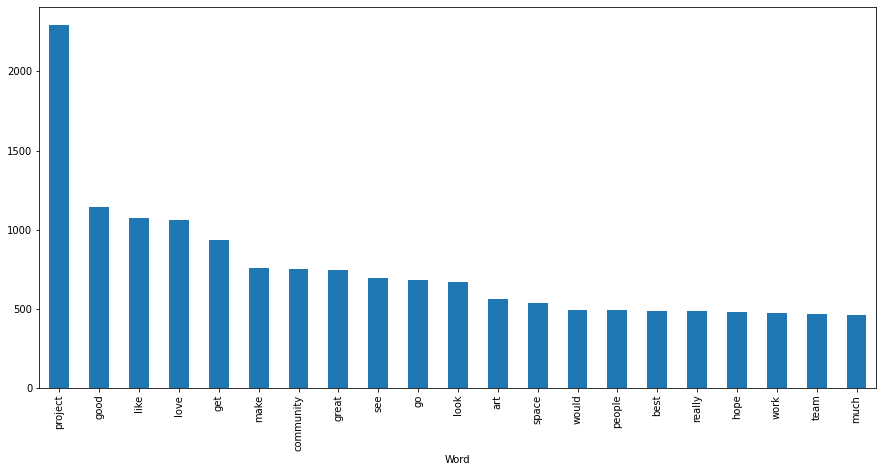

In [ ]:
# A distribuição da ocorrência das 50 palavras mais repetidas nos tweets

graf = tabela_frequencia[tabela_frequencia['Frequency']>414]
graf.plot(kind='bar', x='Word', y='Frequency', figsize=(15,7), legend=False)
plt.show

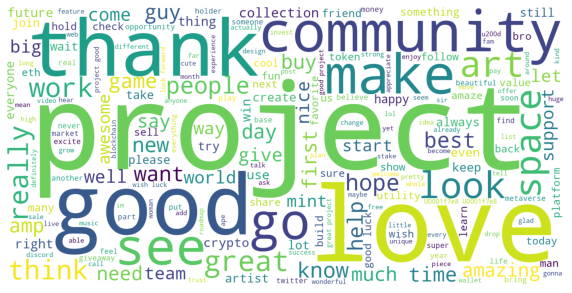

In [ ]:
# gerando a núvem de palavras
wordcloud = WordCloud(background_color = "white", width = 1600, height= 800).generate(texto_unido)

# mostrando imagem
fig, ax = plt.subplots(figsize=(10,6))
ax.imshow(wordcloud, interpolation='bilinear')
ax.set_axis_off()

plt.imshow(wordcloud);
wordcloud.to_file("nft_limpo_wordcloud.png")

### Exploração Visual: Tweets Negativos

In [ ]:
texto_unido = ''
for c in df_negative.token:
  texto_unido += c
texto_unido = texto_unido.replace("'","").replace("[","").replace(",","").replace("]","")

In [ ]:
lista_palavras = []
for tokens in list(texto_unido.split()):
  lista_palavras.append(tokens)

freq_dist_pos = FreqDist(lista_palavras)
tabela_frequencia = pd.DataFrame(list(freq_dist_pos.items()), columns = ["Word","Frequency"]).sort_values(by = "Frequency", ascending = False, ignore_index = True)
tabela_frequencia.head(50)

,Word,Frequency
0,get,231
1,project,138
2,go,136
3,make,126
4,people,115
5,shit,96
6,like,94
7,see,94
8,bad,94
9,scam,92


In [ ]:
# Exportando o dataset com a frequência de palavras entre os textos negativos
writer= pd.ExcelWriter('frequencia_negativos.xlsx', engine= 'xlsxwriter')
tabela_frequencia.to_excel(writer, sheet_name='freq')
writer.save()

In [ ]:
tabela_frequencia[tabela_frequencia['Word']== 'fraud']

,Word,Frequency
224,fraud,13


In [ ]:
# Total de palavras do texto
len(lista_palavras)

17759

In [ ]:
print(f'''\n90% : {np.percentile(tabela_frequencia['Frequency'], 90)}\n
95% : {np.percentile(tabela_frequencia['Frequency'], 95)}\n
99% : {np.percentile(tabela_frequencia['Frequency'], 99)}\n
99,9% : {np.percentile(tabela_frequencia['Frequency'], 99.9).round()}''')


90% : 5.0

95% : 10.0

99% : 38.0

99,9% : 94.0


In [ ]:
# As 50 palavras que mais apareceram representam menos de 1% (0.9996%) do total de palavras do corpus (e se repetem mais de 1434 vezes)
np.percentile(tabela_frequencia['Frequency'], (1 - 50/59578)*100)

95.93756084460802

In [ ]:
(1-(1 - 50/56504))

0.0008848931049129094

<function matplotlib.pyplot.show>

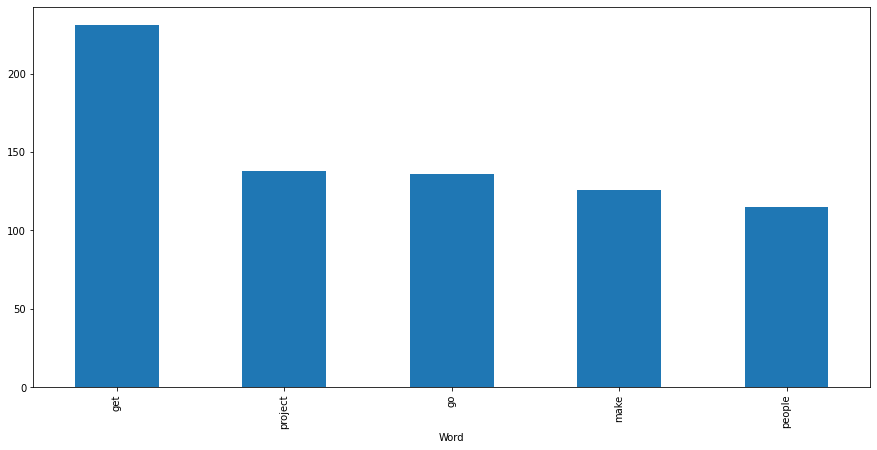

In [ ]:
# A distribuição da ocorrência das 50 palavras mais repetidas nos tweets

graf = tabela_frequencia[tabela_frequencia['Frequency']>97]
graf.plot(kind='bar', x='Word', y='Frequency', figsize=(15,7), legend=False)
plt.show

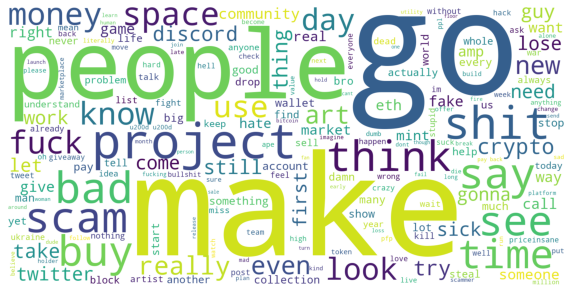

In [ ]:
# gerando a núvem de palavras
wordcloud = WordCloud(background_color = "white", width = 1600, height= 800).generate(texto_unido)

# mostrando imagem
fig, ax = plt.subplots(figsize=(10,6))
ax.imshow(wordcloud, interpolation='bilinear')
ax.set_axis_off()

plt.imshow(wordcloud);
wordcloud.to_file("nft_limpo_wordcloud.png")

### Exploração Visual: Tweets Neutros

In [ ]:
texto_unido = ''
for c in df_neutral.token:
  texto_unido += c
texto_unido = texto_unido.replace("'","").replace("[","").replace(",","").replace("]","")

In [ ]:
lista_palavras = []
for tokens in list(texto_unido.split()):
  lista_palavras.append(tokens)

freq_dist_pos = FreqDist(lista_palavras)
tabela_frequencia = pd.DataFrame(list(freq_dist_pos.items()), columns = ["Word","Frequency"]).sort_values(by = "Frequency", ascending = False, ignore_index = True)
tabela_frequencia.head(50)

,Word,Frequency
0,get,609
1,project,598
2,go,486
3,make,418
4,like,371
5,see,337
6,buy,318
7,think,290
8,look,289
9,know,283


In [ ]:
# Exportando o dataset com a frequência de palavras entre os textos neutros
writer= pd.ExcelWriter('frequencia_neutros.xlsx', engine= 'xlsxwriter')
tabela_frequencia.to_excel(writer, sheet_name='freq')
writer.save()

In [ ]:
# Total de palavras do texto
len(lista_palavras)

61378

In [ ]:
print(f'''\n90% : {np.percentile(tabela_frequencia['Frequency'], 90)}\n
95% : {np.percentile(tabela_frequencia['Frequency'], 95)}\n
99% : {np.percentile(tabela_frequencia['Frequency'], 99)}\n
99,9% : {np.percentile(tabela_frequencia['Frequency'], 99.9).round()}''')


90% : 4.0

95% : 10.0

99% : 46.0

99,9% : 205.0


In [ ]:
# As 50 palavras que mais apareceram representam menos de 1% (0.9996%) do total de palavras do corpus (e se repetem mais de 1434 vezes)
np.percentile(tabela_frequencia['Frequency'], (1 - 50/59578)*100)

227.38950619358366

In [ ]:
(1-(1 - 50/56504))

0.0008848931049129094

<function matplotlib.pyplot.show>

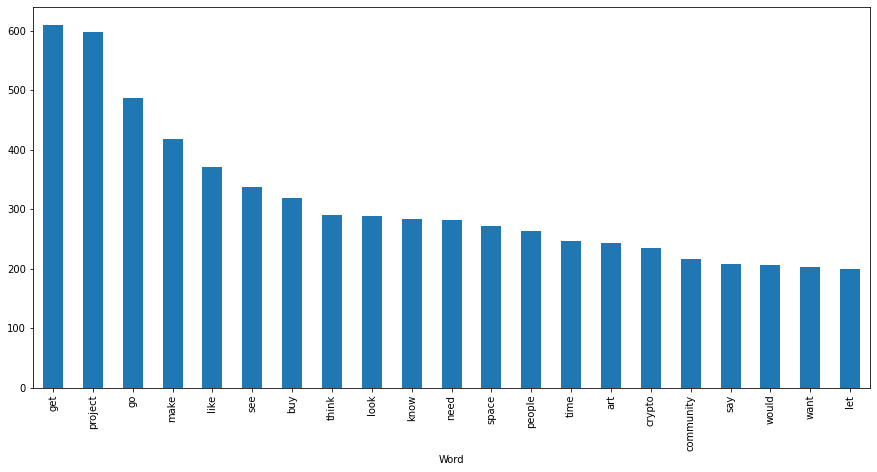

In [ ]:
# A distribuição da ocorrência das 50 palavras mais repetidas nos tweets

graf = tabela_frequencia[tabela_frequencia['Frequency']>197]
graf.plot(kind='bar', x='Word', y='Frequency', figsize=(15,7), legend=False)
plt.show

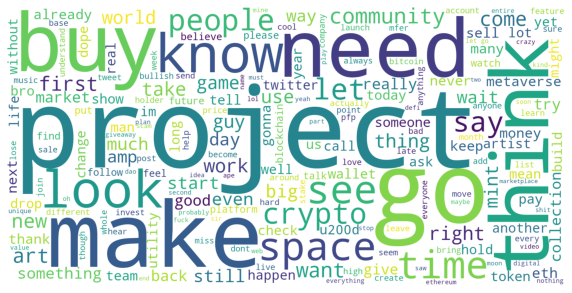

In [ ]:
# gerando a núvem de palavras
wordcloud = WordCloud(background_color = "white", width = 1600, height= 800).generate(texto_unido)

# mostrando imagem
fig, ax = plt.subplots(figsize=(10,6))
ax.imshow(wordcloud, interpolation='bilinear')
ax.set_axis_off()

plt.imshow(wordcloud);
wordcloud.to_file("nft_limpo_wordcloud.png")